# 1. Intro

For an intro and more context about this project click <a href="https://github.com/4rn3/rl_school_project#readme">here<a/>

# 2. Algorithms & setup

In [156]:
import os, time, random
from collections import deque
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation, Monitor

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, Input, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

random.seed(1337)
RANDOM_SEED = 1337
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.GPUOptions(allow_growth=True) #try to avoid out of mem error

print(gym.__version__)
print(tf.__version__) #2.10 last version to support GPU on win
print(tf.config.list_physical_devices('GPU'))

0.19.0
2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [157]:
env = gym.make("SpaceInvaders-v4")
env = GrayScaleObservation(env,keep_dim=True)
env = ResizeObservation(env, (84,84)) #resize
env = FrameStack(env, 4) #gain extra info by combining multiple frames i.e is mario landing or jumping

In [158]:
print("Observation space: ", env.observation_space.shape)
print("# Actions: ", env.action_space.n)
print("Available actions: ", env.get_action_meanings())

Observation space:  (4, 84, 84, 1)
# Actions:  6
Available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [159]:
stacked, height, width, channels = env.observation_space.shape
actions = env.action_space.n

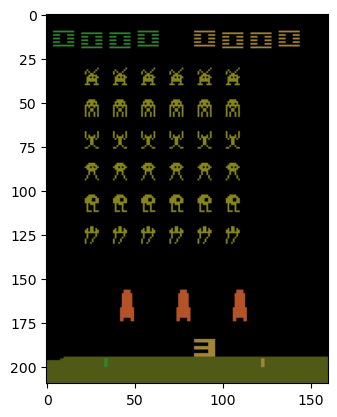

In [160]:
env_screen = env.render(mode = 'rgb_array')
plt.imshow(env_screen)

In [161]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
   
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.savefig(f"./plots/{title}.jpg")
    plt.show()

# 2.1 DQN

In [162]:
#hyp
TRAIN_EPISODE = 1000000
TEST_EPISODE = 10
LR = 1e-4
MEM_LEN = 50000
BATCH_SIZE = 64
UPDATE_TARGET_TRESHOLD = 5
AGGREGATE_STATS = 5
MODEL_NAME = "DQN"
MIN_REPLAY_SIZE = 1000

#Bellman hyp
EPSILON = 1
MAX_EPSILON = 1
MIN_EPSILON = 0.01
DECAY = 0.03
BEL_LR = 0.7
DISCOUNT = 0.66

In [163]:
def agent(state_shape, action_shape):
    
    model = Sequential()
    #Feature generation
    model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(stacked, height, width, channels)))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    #Dim reduction
    model.add(Flatten())
    #FC classifier
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    
    model.compile(loss="mse", optimizer=Adam(learning_rate=LR), metrics=['accuracy'])    
    return model

In [164]:
model = agent(env.observation_space.shape, env.action_space.n) #init prediction model
target_model = agent(env.observation_space.shape, env.action_space.n) #init target model
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=MEM_LEN) #init memory

In [165]:
def batch_train(env, replay_memory, model, target_model, done):
    learning_rate = BEL_LR
    discount_factor = DISCOUNT
    
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    batch_size = BATCH_SIZE
    mini_batch = random.sample(replay_memory, batch_size)
    
    #Predicting the Q-values
    current_states = np.array([transition[0] for transition in mini_batch]) #add current_state from minibatch
    current_qs_list = model.predict(current_states, verbose=0)

    new_current_states = np.array([transition[3]for transition in mini_batch]) #add new_current_state from minibatch
    future_qs_list = target_model.predict(new_current_states, verbose=0)
  
    X, y = [], []

   #Updating Q-values
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward
            
        #Bellman
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        
        X.append(observation)
        y.append(current_qs)
    
    model.fit(np.array(X), np.array(y), batch_size=batch_size, verbose=0, shuffle=False)

In [166]:
#Train loop
X, y, Total_rewards, time_tracking = [], [], [], []
highest_reward = 150
steps_to_update_target_model = 0

total_start = time.time()

for episode in trange(TRAIN_EPISODE):
    n_steps_episode = 0
    total_training_rewards = 0

    observation = env.reset()
    done = False
    
    start = time.time()
    while not done:
        #track time
        
        steps_to_update_target_model += 1
        random_number = np.random.rand()
        #Exploration
        if random_number <= EPSILON:
            action = env.action_space.sample()
        #Exploitation    
        else:
            predicted = model.predict(np.array(observation), verbose=0).flatten()
            action = np.argmax(predicted)

        new_observation, reward, done, info = env.step(action)
        total_training_rewards += reward
        
        replay_memory.append([observation, action, reward, new_observation, done])

        #Update prediction model
        if steps_to_update_target_model % 4 == 0 or done:
            batch_train(env, replay_memory, model, target_model, done)
        
        observation = new_observation
        
        n_steps_episode += 1
        
        if done:
            stop = time.time()
            time_tracking.append(stop-start)
            
            print('{} Total training rewards: {} after n steps = {}'.format(episode, total_training_rewards, n_steps_episode))
            Total_rewards.append(total_training_rewards)

            #Update target model
            if steps_to_update_target_model >= UPDATE_TARGET_TRESHOLD:
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
    
    #Update epsilon 
    EPSILON = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY * episode)
    
    avg_score = round(np.mean(Total_rewards[-100:]),2)
    
    #Save model and metrics
    if (episode % AGGREGATE_STATS == 0) or (total_training_rewards > highest_reward):
        print("Saving model")
        avg_time = round(sum(time_tracking)/len(time_tracking),2) #avg time for aggregate amount of episodes
        
        model.save(f'./models/DQN_models/{str(episode)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/DQN_logs/DQN.txt","a") as f:
            f.write(f"{avg_score},{total_training_rewards},{avg_time},{str(episode)},{n_steps_episode}\n")
        
        time_tracking = []
        
        if total_training_rewards > highest_reward:
            highest_reward = total_training_rewards
        
env.close()
total_stop = time.time()
total_time = total_stop-total_start

  0%|          | 0/1000000 [00:00<?, ?it/s]

0 Total training rewards: 110.0 after n steps = 574
Saving model
1 Total training rewards: 240.0 after n steps = 903
Saving model
2 Total training rewards: 185.0 after n steps = 707
3 Total training rewards: 35.0 after n steps = 572
4 Total training rewards: 45.0 after n steps = 538
5 Total training rewards: 105.0 after n steps = 546
Saving model
6 Total training rewards: 155.0 after n steps = 784
7 Total training rewards: 260.0 after n steps = 917
Saving model
8 Total training rewards: 120.0 after n steps = 575
9 Total training rewards: 560.0 after n steps = 1060
Saving model
10 Total training rewards: 70.0 after n steps = 352
Saving model
11 Total training rewards: 70.0 after n steps = 517
12 Total training rewards: 180.0 after n steps = 802
13 Total training rewards: 155.0 after n steps = 707
14 Total training rewards: 135.0 after n steps = 643
15 Total training rewards: 55.0 after n steps = 493
Saving model
16 Total training rewards: 305.0 after n steps = 1514
17 Total training rew

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


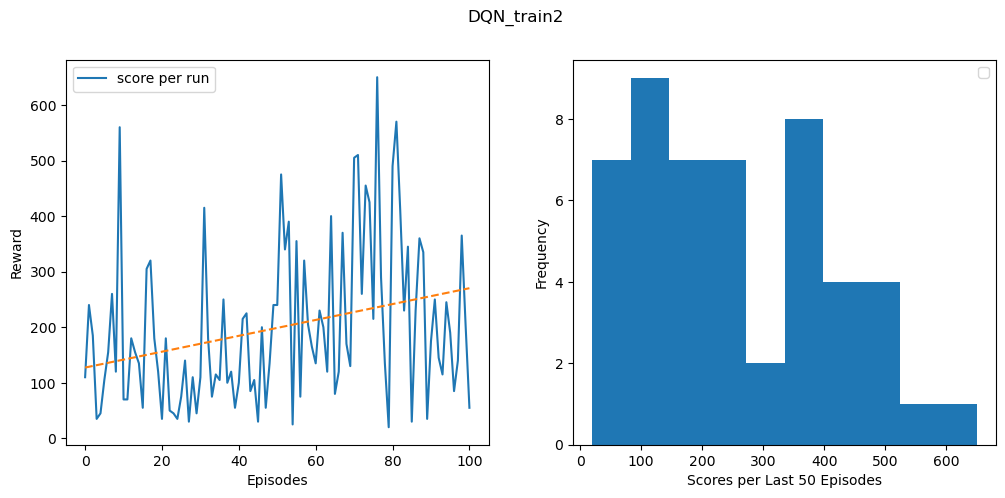

In [167]:
#Plot trainig
plot_res(Total_rewards,'DQN_train2')

### 2.1.1 Log analysis

In [168]:
#Highest average rewards
dqn_df = pd.read_csv('./logs/DQN_logs/DQN1.csv')

In [169]:
dqn_df[dqn_df["episode"] > 50].sort_values(by=["avg_score","episode"], ascending=False).head(10)

,avg_score,total_training_rewards,avg_time,episode,steps
23,200.93,175.0,146.68,90,1259
24,200.31,190.0,119.25,95,698
25,199.70,55.0,130.68,100,400
22,199.42,30.0,128.00,85,419
21,192.16,490.0,87.11,80,1109
20,190.00,650.0,139.16,76,1167
19,183.95,215.0,126.28,75,913
18,170.63,505.0,77.09,70,1081
17,163.94,80.0,57.62,65,495
16,160.49,135.0,64.68,60,849


In [170]:
#highest max reward (influecned by steps)
dqn_df.sort_values(by=["total_training_rewards","episode"], ascending=False).head(10)

,avg_score,total_training_rewards,avg_time,episode,steps
20,190.00,650.0,139.16,76,1167
5,181.50,560.0,28.07,9,1060
18,170.63,505.0,77.09,70,1081
21,192.16,490.0,87.11,80,1109
15,158.75,355.0,67.22,55,1164
4,141.88,260.0,27.95,7,917
14,143.24,240.0,41.10,50,859
2,175.00,240.0,14.66,1,903
19,183.95,215.0,126.28,75,913
24,200.31,190.0,119.25,95,698


### 2.1.2 Evaluation

In [181]:
### Load models
best_dqn_model = "76_DQN.h5"
best_dqn_model = load_model(os.path.join("./models/DQN_models",best_dqn_model), compile=False)

In [183]:
#Evaluate model
Total_reward = []
for episode in trange(TEST_EPISODE):
        n_steps_episode = 0
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            observation = tf.expand_dims(observation, 0)
            
            predicted = best_dqn_model.predict(observation, verbose=0)
            action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            total_training_rewards += reward  
            observation = new_observation
            
            n_steps_episode += 1
        print('{} Reward = {}'.format(episode,total_training_rewards))
        Total_reward.append(total_training_rewards)
env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

0 Reward = 150.0
1 Reward = 170.0
2 Reward = 435.0
3 Reward = 80.0
4 Reward = 345.0
5 Reward = 165.0
6 Reward = 320.0
7 Reward = 205.0
8 Reward = 125.0
9 Reward = 220.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


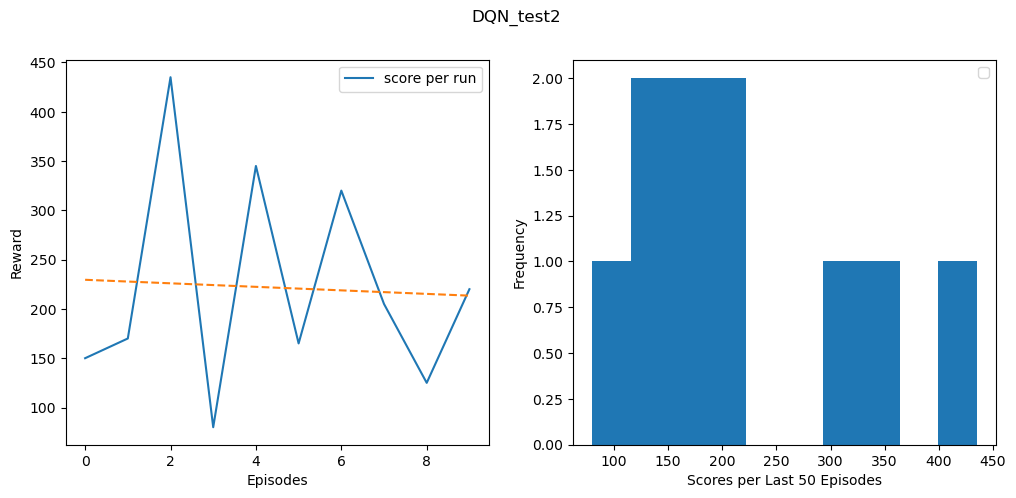

In [184]:
plot_res(Total_reward,'DQN_test2')

# 2.2 Actor-Critic

In [198]:
#hyp
TRAIN_EPISODE = 10
TEST_EPISODE = 10
LR = 1e-4
GOAL = 1000
AGGREGATE_STATS = 5
MAX_STEPS_PER_EPISODEE = 30000
MODEL_NAME = "AC"
GAMMA = 0.99 
EPS = np.finfo(np.float32).eps.item() #smallest number such that 1.0 + eps != 1.0

In [199]:
#Input
inputs = Input((height, width, channels))

#Feature generation
features = Conv2D(32, (8,8), strides=(4,4), activation='relu')(inputs)
features = Conv2D(64, (4,4), strides=(2,2), activation='relu')(features)
features = Conv2D(128, (3,3), activation='relu')(features)

#Dim reduction
flatten = Flatten()(features)

fc1 = Dense(512, activation='relu')(flatten)
fc2 = Dense(256, activation='relu')(fc1)

actor = Dense(env.action_space.n, activation="softmax")(fc2)
critic = Dense(1)(fc2)

# Construct the model
model = keras.Model(inputs=inputs, outputs=[actor, critic])
print(model.summary())

# Add adam optimizer and Huber loss
optimizer = keras.optimizers.Adam(learning_rate=LR)
huber_loss = keras.losses.Huber()

model.compile(optimizer=optimizer, loss=huber_loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 20, 20, 32)   2080        ['input_1[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 9, 9, 64)     32832       ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 7, 7, 128)    73856       ['conv2d_13[0][0]']              
                                                                                              

In [201]:
%%time #timed using for instead of while

action_probs_history = []
critic_value_history = []
rewards_history = []
score_history = []

highest_reward = 150

average_reward = 0
episode_count = 0


while True:
    state = env.reset()
    episode_reward = 0
    time_tracking = []
    with tf.GradientTape() as tape:
        start_time = time.time()
        for timestep in range(1, MAX_STEPS_PER_EPISODEE):
            
            state = tf.convert_to_tensor(state)
            
            action_probs, critic_value = model(state)
            
            p = np.squeeze(action_probs)
            
            action = np.random.choice(env.action_space.n, p=p[0])
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            
            critic_value_history.append(critic_value[0, 0])

            state, reward, done, info = env.step(action)
            
            rewards_history.append(reward)
            episode_reward += reward
            
            if done:
                stop_time = time.time()
                time_tracking.append(stop_time-start_time)
                break
        
        score_history.append(episode_reward)
                
        # Calculate expected value from rewards
        G = np.zeros_like(rewards_history)
        for t in range(len(rewards_history)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards_history)):
                G_sum += rewards_history[k]*discount
                discount *= GAMMA
            G[t] = G_sum
        
        # normalize
        G = np.array(G)
        G = (G - np.mean(G)) / (np.std(G) + EPS)
        G = G.tolist()
        
        history = zip(action_probs_history, critic_value_history, G)

        actor_losses = []
        critic_losses = []
        
        for log_prob, value, rew in history:
            diff = rew - value
            #update actor
            actor_losses.append(-log_prob * diff) # actor loss
            #update critic
            critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(rew, 0)))
        
        ## Combine losses
        loss_value = sum(actor_losses) + sum(critic_losses)
        
        grads = tape.gradient(loss_value, model.trainable_variables)
        
        #backprop
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        

    episode_count += 1
    
    avg_score = np.mean(score_history[-100:])
    
     #Save model and metrics
    if (episode_count % AGGREGATE_STATS == 0) or (episode_reward > highest_reward):
        print(f"episode: {episode_count}, avg score: {round(avg_score,2)}")
        avg_time = round(sum(time_tracking)/len(time_tracking),2) #avg time for aggregate amount of episodes
        
        model.save(f'./models/AC_models/{str(episode_count)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/AC_logs/AC.txt","a") as f:
            f.write(f"{round(avg_score,2)},{episode_reward},{avg_time},{episode_count}\n")
            
        if episode_reward > highest_reward:
            highest_reward = episode_reward 
            
    if avg_score > GOAL:
        model.save(f'./models/AC_models/{str(episode_count)}_{MODEL_NAME}.h5')
        print("Solved at episode {}!".format(episode_count))
        break

episode: 1, avg score: 210.0
episode: 4, avg score: 186.25
episode: 5, avg score: 206.0
CPU times: total: 1min 29s
Wall time: 1min 29s


89.86965847015381

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


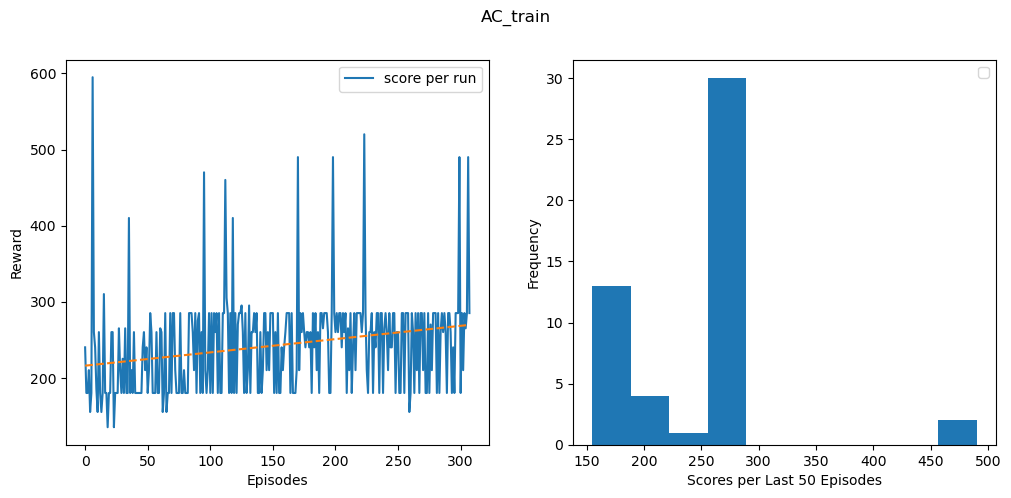

In [12]:
plot_res(score_history,'AC_train')

### 2.2.1 Log analytics

In [84]:
ac_df = pd.read_csv('./logs/AC_logs/AC1.csv')
ac_df.sort_values(by=["avg_score", "episode_reward"], ascending=False).head(5)

,avg_score,episode_reward,avg_time,epsiode_count,steps
55,258.35,285.0,3.64,270,NaN
53,257.30,155.0,3.14,260,NaN
54,256.25,285.0,3.61,265,NaN
52,255.90,285.0,3.62,255,NaN
51,255.90,260.0,3.70,250,NaN


In [18]:
ac_df.sort_values(by=["episode_reward","avg_score"], ascending=False).head(5)

,avg_score,episode_reward,avg_time,epsiode_count,steps
2,248.57,595.0,6.04,7,NaN
61,253.80,490.0,4.02,300,NaN
55,258.35,285.0,3.64,270,NaN
54,256.25,285.0,3.61,265,NaN
52,255.90,285.0,3.62,255,NaN


### 2.2.2 Evaluation

In [53]:
### Load the best model
best_ac_model = "7_AC.h5"
best_ac_model = load_model(os.path.join("./models/AC_models",best_ac_model), compile=False)

In [43]:
score_history = []
n_episodes = 10

for i in trange(n_episodes):
        done = False
        score = 0
        observation = env.reset()
        
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            
            action_probs, critic_value = best_ac_model(observation)
            p = np.squeeze(action_probs)

            action = np.random.choice(env.action_space.n, p=p[0])
            observation, reward, done, info = env.step(action)
            score += reward
        
        score_history.append(score)
        
        avg_score = np.mean(score_history[-100:])
        print('episode ', i,  'avg score %.1f' % avg_score)

  0%|          | 0/10 [00:00<?, ?it/s]

episode  0 avg score 180.0
episode  1 avg score 167.5
episode  2 avg score 163.3
episode  3 avg score 135.0
episode  4 avg score 130.0
episode  5 avg score 143.3
episode  6 avg score 160.0
episode  7 avg score 166.2
episode  8 avg score 167.8
episode  9 avg score 162.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


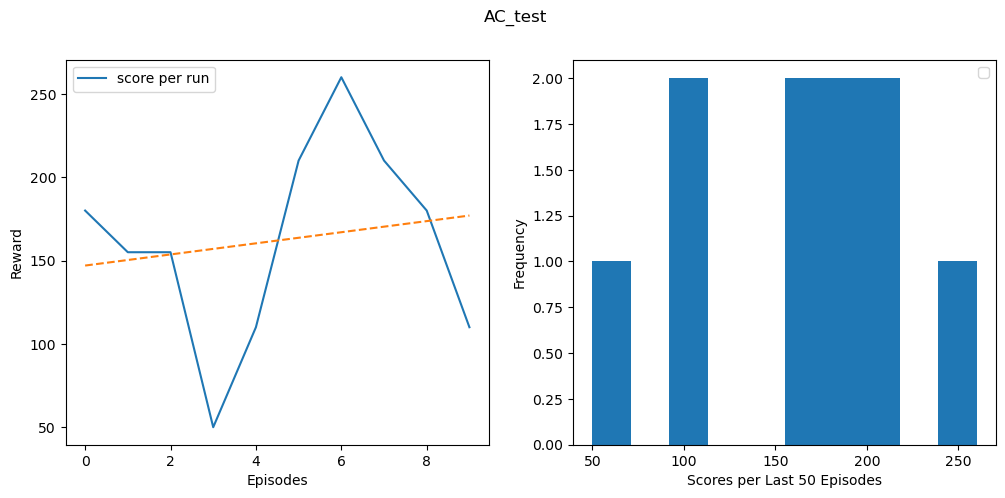

In [44]:
plot_res(score_history,'AC_test')

### 3 Comparison

### 3.1 Models compared to random actions

In [79]:
#play 1 game with random actions
epochs, rndm_rewards = 0, 0

observation = env.reset()
done = False


while not done:
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    rndm_rewards  += reward
    epochs += 1
    time.sleep(0.05)
    
env.close()
print(f"Reward: {rndm_rewards}")

Reward: 105.0


In [64]:
#play 1 game of the dqn best model
epochs, dqn_rewards = 0, 0
observation = env.reset()
done = False

while not done:
    
    observation = tf.convert_to_tensor(observation)
    observation = tf.expand_dims(observation, 0)
    
    predicted = best_dqn_model.predict(np.array(observation), verbose=0).flatten()
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    dqn_rewards  += reward
    epochs += 1
    time.sleep(0.05)
    
env.close()
print(f"Reward: {dqn_rewards}") 

Reward: 335.0


In [74]:
#play 1 game of the ac best model
epochs, ac_rewards = 0, 0
observation = env.reset()
done = False

while not done:
    observation = tf.convert_to_tensor(observation)
            
    action_probs, critic_value = best_ac_model(observation)
    p = np.squeeze(action_probs)

    action = np.random.choice(env.action_space.n, p=p[0])
    observation, reward, done, info = env.step(action)
    env.render()
    ac_rewards += reward
    time.sleep(0.05)
    
env.close()
print(f"Reward: {ac_rewards}") 

Reward: 210.0


### 3.2 Anaylitical comparison

In [185]:
print("DQN Highest avg score: ", dqn_df[dqn_df["episode"] > 50].sort_values(by=["avg_score","episode"], ascending=False)['avg_score'].iloc[0])
print("AC Highest avg score: ", ac_df.sort_values(by=["avg_score", "episode_reward"], ascending=False)['avg_score'].iloc[0])

DQN Highest avg score:  200.93
AC Highest avg score:  258.35


In [186]:
print("DQN Highest highest ep score: ", dqn_df.sort_values(by=["total_training_rewards","episode"], ascending=False)['total_training_rewards'].iloc[0])
print("AC Highest highest ep score: ", ac_df.sort_values(by=["episode_reward","epsiode_count"], ascending=False)['episode_reward'].iloc[0])

DQN Highest highest ep score:  650.0
AC Highest highest ep score:  595.0


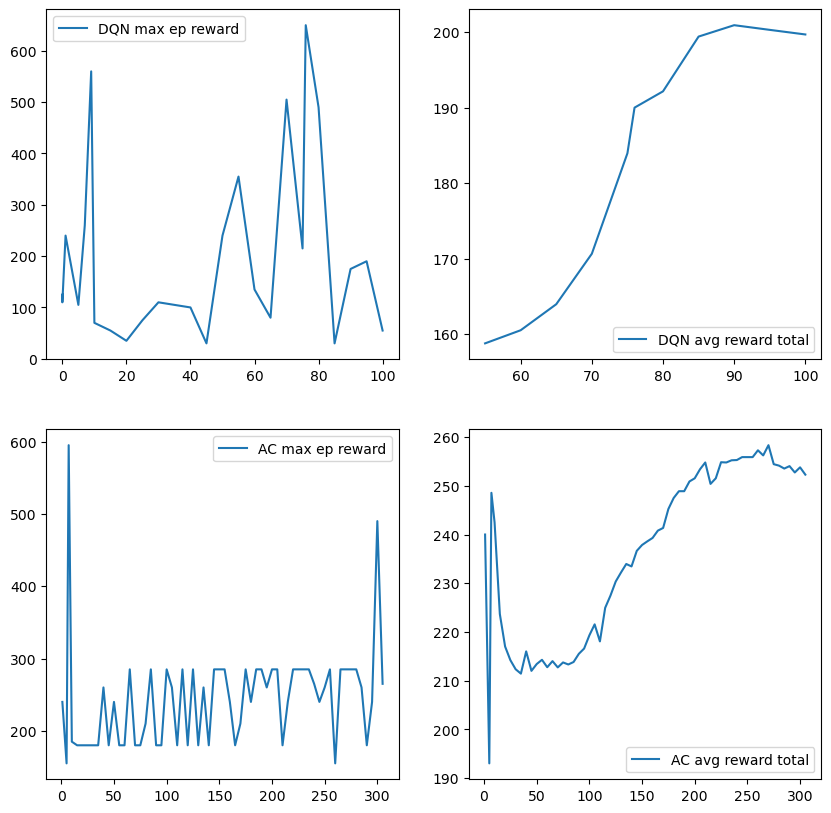

In [188]:
#Max & AVG rewards per episode 
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0][0].plot(dqn_df["episode"], dqn_df["total_training_rewards"], label="DQN max ep reward")
axs[0][0].legend(loc="upper left")
axs[0][1].plot(dqn_df[dqn_df["episode"] > 50]["episode"], dqn_df[dqn_df["episode"] > 50]["avg_score"], label="DQN avg reward total")
axs[0][1].legend(loc="lower right")

axs[1][0].plot(ac_df["epsiode_count"], ac_df["episode_reward"], label="AC max ep reward")
axs[1][0].legend(loc="upper right")
axs[1][1].plot(ac_df["epsiode_count"], ac_df["avg_score"], label="AC avg reward total")
axs[1][1].legend(loc="lower right")

1287.31


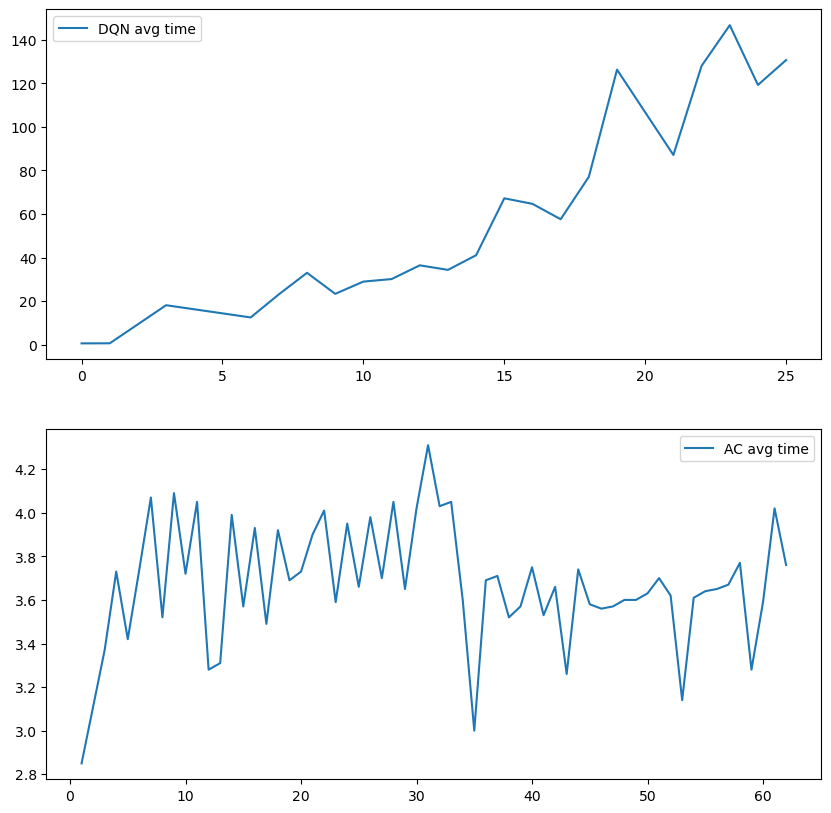

In [193]:
dqn_time = dqn_df[dqn_df["episode"] % 5 ==0]
ac_time = ac_df[ac_df["epsiode_count"] % 5 ==0]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 10))
ax1.plot(dqn_time["avg_time"], label="DQN avg time")
ax1.legend(loc="best")
ax2.plot(ac_time["avg_time"], label="AC avg time")
ax2.legend(loc="best")

print(dqn_time["avg_time"].sum())